In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.models.segmentation as segmentation
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import pandas as pd
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline
import random
# plt.style.use('_mpl-gallery')


/opt/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# MODEL INITIALISE

In [3]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = segmentation.deeplabv3_resnet50(
            weights=segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
        )
        self.backbone.classifier[-1] = nn.Conv2d(256, num_classes, 1)
        self.backbone.aux_classifier = None
        
    def forward(self, x):
        return self.backbone(x)['out']

# DATASET INITIALISE

In [5]:
class TurtleSegDataset(Dataset):
    def __init__(self, coco_path, img_dir, image_ids=None, transform=None):
        self.coco = COCO(coco_path)
        self.img_dir = img_dir
        self.transform = transform
        self.ids = image_ids if image_ids is not None else list(self.coco.imgs.keys())
        
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'].split('images/')[-1])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # create masks: 3 channels for turtle, flipper, head
        h, w = image.shape[:2]
        masks = np.zeros((3, h, w), dtype=np.uint8)
        
        # get all annotations for this image
        anns_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(anns_ids)
        
        # create masks for each category
        for ann in anns:
            category_id = ann['category_id'] - 1
            mask = self.coco.annToMask(ann)
            masks[category_id] = np.logical_or(masks[category_id], mask)
        
        # separate masks
        mask1 = masks[0]
        mask2 = masks[1]
        mask3 = masks[2]
        
        # create a combined mask for visualization
        combined = {
            'image': image,
            'mask1': mask1,
            'mask2': mask2,
            'mask3': mask3
        }
        
        # apply transformations
        if self.transform:
            augmented = self.transform(**combined)
            image = augmented['image']
            mask1 = augmented['mask1']
            mask2 = augmented['mask2']
            mask3 = augmented['mask3']
            masks = np.stack([mask1, mask2, mask3], axis=0)
        
        # (H, W) -> (1, H, W)
        masks = torch.from_numpy(masks).float()
        
        return image, masks
    
    def __len__(self):
        return len(self.ids)

In [6]:
def create_dataloaders(base_path, batch_size=8):
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    img_dir = os.path.join(base_path, 'images')
    ann_path = os.path.join(base_path, 'annotations.json')
    splits_path = os.path.join(base_path, 'metadata_splits.csv')
    
    # read the splits
    splits_df = pd.read_csv(splits_path)
    train_ids = splits_df[splits_df['split_open'] == 'train']['id'].tolist()
    val_ids = splits_df[splits_df['split_open'] == 'valid']['id'].tolist()
    test_ids = splits_df[splits_df['split_open'] == 'test']['id'].tolist()
    
    print(f"Number of training samples: {len(train_ids)}")
    print(f"Number of validation samples: {len(val_ids)}")
    print(f"Number of test samples: {len(test_ids)}")

    # define base transform
    base_transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], additional_targets={
        'mask1': 'mask',
        'mask2': 'mask',
        'mask3': 'mask'
    })
    
    # define train transform
    train_transform = A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], additional_targets={
        'mask1': 'mask',
        'mask2': 'mask',
        'mask3': 'mask'
    })
    
    # create datasets
    train_dataset = TurtleSegDataset(
        coco_path=ann_path,
        img_dir=img_dir,
        image_ids=train_ids,
        transform=train_transform
    )
    
    val_dataset = TurtleSegDataset(
        coco_path=ann_path,
        img_dir=img_dir,
        image_ids=val_ids,
        transform=base_transform
    )
    
    test_dataset = TurtleSegDataset(
        coco_path=ann_path,
        img_dir=img_dir,
        image_ids=test_ids,
        transform=base_transform
    )
    
    # create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        num_workers=0,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [7]:
def calculate_metrics(pred, target):
    # calculate metrics for each class
    metrics_per_class = []
    for c in range(pred.shape[1]):
        pred_class = pred[:, c]
        target_class = target[:, c]
        
        intersection = (pred_class & target_class).sum().float()
        union = (pred_class | target_class).sum().float()
        
        iou = (intersection + 1e-10) / (union + 1e-10)
        dice = (2 * intersection + 1e-10) / (pred_class.sum() + target_class.sum() + 1e-10)
        
        metrics_per_class.append({
            'iou': iou.item(),
            'dice': dice.item()
        })
    
    return metrics_per_class

In [8]:
def visualize_batch(images, masks, preds=None, save_path=None):
    """Visualize two sets of images, masks, and predictions"""
    plt.figure(figsize=(15, 5))
    
    # Color mapping
    colors = [
        [65, 105, 225],  # Turtle body - blue
        [50, 205, 50],   # Flipper - green
        [255, 255, 0]    # Head - yellow
    ]
    
    for i in range(min(2, images.shape[0])):
        # Process image
        img = images[i].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = torch.clamp(img, 0, 1)
        
        plt.subplot(2, 3, i*3 + 1)
        plt.imshow(img.permute(1,2,0))
        plt.title(f'Image {i+1}')
        plt.axis('off')
        
        # Show Ground Truth
        mask_vis = np.zeros((*masks[i].shape[1:], 3), dtype=np.uint8)
        for c in range(3):
            mask = masks[i][c].cpu().numpy()
            color = np.array(colors[c])
            mask_vis[mask > 0] = color
        
        plt.subplot(2, 3, i*3 + 2)
        plt.imshow(mask_vis)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        if preds is not None:
            pred_vis = np.zeros((*preds[i].shape[1:], 3), dtype=np.uint8)
            for c in range(3):
                pred = preds[i][c].cpu().numpy()
                color = np.array(colors[c])
                pred_vis[pred > 0] = color
            
            plt.subplot(2, 3, i*3 + 3)
            plt.imshow(pred_vis)
            plt.title(f'Prediction {i+1}')
            plt.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=8, start_epoch=0, checkpoint_path=None):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        best_val_loss = checkpoint.get('best_val_loss', np.inf)
        start_epoch = checkpoint.get('epoch', -1) + 1
        print(f"Resuming from epoch {start_epoch} with best Validation Loss: {best_val_loss:.4f}")
    else:
        model = model.to(device)
        best_val_loss = np.inf
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    scheduler = CosineAnnealingLR(
        optimizer, 
        T_max=num_epochs - start_epoch,
        eta_min=1e-6
    )
    
    class_names = ['Turtle', 'Flipper', 'Head']
    
    # Initialize lists to record metrics
    avg_train_losses_per_epoch = []
    avg_val_losses_per_epoch = []
    per_class_iou = {name: [] for name in class_names}
    mean_iou_per_epoch = []
    
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_metrics = {name: {'iou': [], 'dice': []} for name in class_names}
        batch_train_losses = []
        
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (images, masks) in enumerate(train_bar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                preds = (outputs.sigmoid() > 0.5)
                metrics = calculate_metrics(preds, masks.bool())
                for idx, name in enumerate(class_names):
                    train_metrics[name]['iou'].append(metrics[idx]['iou'])
                    train_metrics[name]['dice'].append(metrics[idx]['dice'])
            
            train_loss += loss.item()
            batch_train_losses.append(loss.item())
            
            mean_iou = np.mean([np.mean(train_metrics[name]['iou']) for name in class_names])
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mean_iou': f'{mean_iou:.4f}'
            })
            
            # Visualize first batch of each epoch
            if batch_idx == 0:
                visualize_batch(images, masks, preds)
        
        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)
        avg_train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_metrics = {name: {'iou': [], 'dice': []} for name in class_names}
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc='Validating'):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                preds = (outputs.sigmoid() > 0.5)
                metrics = calculate_metrics(preds, masks.bool())
                for idx, name in enumerate(class_names):
                    val_metrics[name]['iou'].append(metrics[idx]['iou'])
                    val_metrics[name]['dice'].append(metrics[idx]['dice'])
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_losses_per_epoch.append(avg_val_loss)
        
        for name in class_names:
            mean_iou = np.mean(val_metrics[name]['iou'])
            per_class_iou[name].append(mean_iou)
        
        current_mean_iou = np.mean([np.mean(val_metrics[name]['iou']) for name in class_names])
        mean_iou_per_epoch.append(current_mean_iou)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        print('\nTraining Metrics:')
        for name in class_names:
            mean_iou = np.mean(train_metrics[name]['iou'])
            mean_dice = np.mean(train_metrics[name]['dice'])
            print(f'{name} - IoU: {mean_iou:.4f}, Dice: {mean_dice:.4f}')
        
        print('\nValidation Metrics:')
        for name in class_names:
            mean_iou = np.mean(val_metrics[name]['iou'])
            mean_dice = np.mean(val_metrics[name]['dice'])
            print(f'{name} - IoU: {mean_iou:.4f}, Dice: {mean_dice:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, 'checkpoints/best_model.pth')
            print(f'New best model saved! Validation Loss: {best_val_loss:.4f}')
        
        os.makedirs('checkpoints', exist_ok=True)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'best_val_loss': best_val_loss
        }
        torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')
        
        scheduler.step()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    epochs = range(1, len(avg_train_losses_per_epoch) + 1)
    plt.plot(epochs, avg_train_losses_per_epoch, 'bo-', label='Average Training Loss')
    plt.plot(epochs, avg_val_losses_per_epoch, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot IoU curves
    plt.subplot(1, 2, 2)
    for class_name, iou_list in per_class_iou.items():
        plt.plot(epochs, iou_list, marker='o', label=f'{class_name} IoU')
    plt.plot(epochs, mean_iou_per_epoch, marker='x', linestyle='--', 
            color='black', label='Mean IoU')
    plt.title('Validation IoU Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

# TRAINING PHASE

Number of training samples: 5303
Number of validation samples: 1118
Number of test samples: 2308
loading annotations into memory...
Done (t=1.49s)
creating index...
index created!
loading annotations into memory...
Done (t=1.56s)
creating index...
index created!
loading annotations into memory...
Done (t=1.61s)
creating index...
index created!
Using device: mps


Training Epoch 1/25:   0%|          | 0/663 [00:00<?, ?it/s]

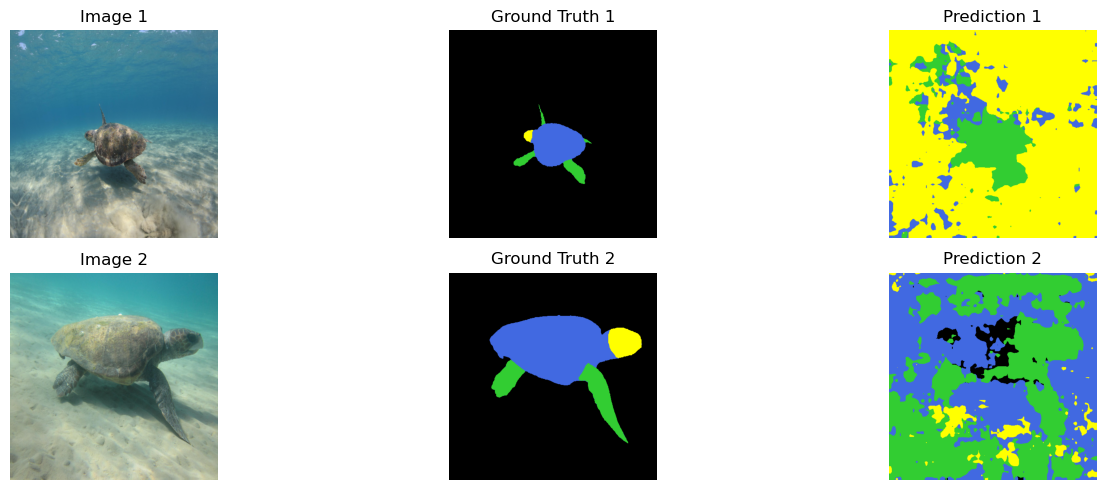

KeyboardInterrupt: 

In [11]:
torch.manual_seed(42)
np.random.seed(42)

os.makedirs('checkpoints', exist_ok=True)
base_path = 'data'


# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    base_path,
    batch_size=8
)

model = DeepLabV3Plus(num_classes=3)

num_epochs = 25
checkpoint_path = None

model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    checkpoint_path=checkpoint_path
)

print("Training completed!")


# Evaluation Part:

In [ ]:
class TurtleSegDataset(Dataset):
    def __init__(self, coco_path, img_dir, image_ids=None, transform=None):
        self.coco = COCO(coco_path)
        self.img_dir = img_dir
        self.transform = transform
        self.ids = image_ids if image_ids is not None else list(self.coco.imgs.keys())
        
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'].split('images/')[-1])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        h, w = image.shape[:2]
        masks = np.zeros((3, h, w), dtype=np.uint8)
        
        anns_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(anns_ids)
        
        for ann in anns:
            category_id = ann['category_id'] - 1  # Convert to 0-based index
            mask = self.coco.annToMask(ann)
            masks[category_id] = np.logical_or(masks[category_id], mask)
        
        mask1 = masks[0]
        mask2 = masks[1]
        mask3 = masks[2]
        
        combined = {
            'image': image,
            'mask1': mask1,
            'mask2': mask2,
            'mask3': mask3
        }
        
        if self.transform:
            augmented = self.transform(**combined)
            image = augmented['image']
            mask1 = augmented['mask1']
            mask2 = augmented['mask2']
            mask3 = augmented['mask3']
            masks = np.stack([mask1, mask2, mask3], axis=0)
        
        masks = torch.from_numpy(masks).float()
        
        return image, masks
    
    def __len__(self):
        return len(self.ids)


In [ ]:
def create_test_loader(base_path, batch_size=8):
    """Create test data loader"""
    img_dir = os.path.join(base_path, 'images')
    ann_path = os.path.join(base_path, 'annotations.json')
    splits_path = os.path.join(base_path, 'metadata_splits.csv')
    
    splits_df = pd.read_csv(splits_path)
    test_ids = splits_df[splits_df['split_open'] == 'test']['id'].tolist()
    
    print(f"Number of test samples: {len(test_ids)}")
    
    test_transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], additional_targets={
        'mask1': 'mask',
        'mask2': 'mask',
        'mask3': 'mask'
    })
    
    test_dataset = TurtleSegDataset(
        coco_path=ann_path,
        img_dir=img_dir,
        image_ids=test_ids,
        transform=test_transform
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        num_workers=0,
        pin_memory=True
    )
    
    return test_loader


In [ ]:
def visualize_prediction(image, masks, preds):
    """Visualize prediction results"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    img_np = image.permute(1,2,0).numpy()
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')
    
    # Color mapping
    colors = [
        [65, 105, 225],  # Turtle body - Blue
        [50, 205, 50],   # Flipper - Green
        [255, 255, 0]    # Head - Yellow
    ]
    
    plt.subplot(132)
    gt_vis = np.zeros((*masks.shape[1:], 3), dtype=np.uint8)
    for i in range(3):
        mask = masks[i].numpy()
        color = np.array(colors[i])
        gt_vis[mask > 0] = color
    plt.imshow(gt_vis)
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(133)
    pred_vis = np.zeros((*preds.shape[1:], 3), dtype=np.uint8)
    for i in range(3):
        pred = preds[i].numpy()
        color = np.array(colors[i])
        pred_vis[pred > 0] = color
    plt.imshow(pred_vis)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()


In [ ]:
def evaluate_model(model_path, test_loader):
    """Evaluate model performance"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = DeepLabV3Plus(num_classes=3)
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    class_names = ['Turtle', 'Flipper', 'Head']
    metrics_per_class = {name: {'iou': [], 'dice': []} for name in class_names}
    
    images_to_plot = []
    
    print("Starting evaluation...")
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            masks = masks.to(device).bool()
            
            # Predict
            outputs = model(images)
            preds = (outputs.sigmoid() > 0.5).bool()
            
            for i in range(3):
                pred_class = preds[:, i]
                mask_class = masks[:, i]
                
                intersection = torch.logical_and(pred_class, mask_class).sum(dim=(1,2)).float()
                union = torch.logical_or(pred_class, mask_class).sum(dim=(1,2)).float()
                
                iou = (intersection + 1e-10) / (union + 1e-10)
                dice = (2 * intersection + 1e-10) / (pred_class.sum(dim=(1,2)).float() + mask_class.sum(dim=(1,2)).float() + 1e-10)
                
                metrics_per_class[class_names[i]]['iou'].extend(iou.cpu().numpy())
                metrics_per_class[class_names[i]]['dice'].extend(dice.cpu().numpy())
            
            if len(images_to_plot) < 10:
                for i in range(images.shape[0]):
                    if len(images_to_plot) < 10:
                        img = images[i].cpu()
                        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                              torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
                        img = torch.clamp(img, 0, 1)
                        
                        images_to_plot.append((img, masks[i].cpu(), preds[i].cpu()))
                    else:
                        break
    
    results = {}
    print("\nEvaluation Results:")
    for class_name in class_names:
        mean_iou = np.mean(metrics_per_class[class_name]['iou'])
        mean_dice = np.mean(metrics_per_class[class_name]['dice'])
        
        print(f"\n{class_name}:")
        print(f"Mean IoU: {mean_iou:.4f}")
        print(f"Mean Dice: {mean_dice:.4f}")
        
        results[class_name] = {
            'iou': mean_iou,
            'dice': mean_dice
        }
    
    overall_iou = np.mean([results[name]['iou'] for name in class_names])
    overall_dice = np.mean([results[name]['dice'] for name in class_names])
    
    print(f"\nOverall:")
    print(f"Mean IoU: {overall_iou:.4f}")
    print(f"Mean Dice: {overall_dice:.4f}")
    

    
    for img, mask, pred in images_to_plot:
        visualize_prediction(
            image=img,
            masks=mask,
            preds=pred
        )
    
    return results


In [ ]:
base_path = r'C:\Users\huxia\Desktop\comp9517\lab\group_project\group_project'
model_path = r'C:\Users\huxia\Desktop\comp9517\lab\group_project\group_project\code\checkpoints\best_model.pth'

test_loader = create_test_loader(base_path)

results = evaluate_model(
    model_path=model_path,
    test_loader=test_loader
)
